In [9]:
!pip install quandl

  Running setup.py bdist_wheel for inflection ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
############################################## Imports ###############################################
#import general packages
from req_imports import *

#import defined functions
from functions_defined import *

import quandl

quandl.ApiConfig.api_key = 'VxZss34XgZXejjDqgZJr'

In [11]:
######################################## Variable Initialization ########################################
tf.logging.set_verbosity('ERROR')

#Data start date
start_date='01-01-1980'
#data end date
end_date='14-06-2019'

#stock name
stock_name='GOOGL'

#return period
default_return_period=1

#train validation test splits
train_fraction=0.6
val_fraction=0.15

train_fraction1=1
val_fraction1=0.01

#lags
lags = 10
lags_ann=50

#multinomial returns true or false
multinomial_ret=1

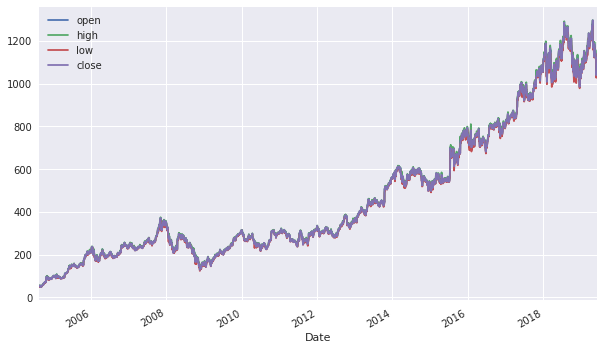

In [12]:
########################### Sourcing Data, obtaining features  ############################################

#Getting Historical Data
data = quandl.get('EOD/' + stock_name, start_date=start_date, end_date=end_date)
data=data[['Adj_Open','Adj_Close','Adj_High','Adj_Low','Adj_Volume']]
#data = pd.DataFrame(web.DataReader(stock_name, data_source='yahoo',start=start_date, end=end_date))

#data=data.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})
data=data.rename(columns = {'Adj_Open':'open','Adj_High':'high','Adj_Low':'low','Adj_Close':'close','Adj_Volume':'volume'})

#Plot data
data[['open','high','low','close']].plot(figsize=(10, 6))

#Obtain features using OHLC data
clfi=[1]
data['r'] = np.log(data['close'] / data['close'].shift(default_return_period))
data['rs'] = (data['r'] - data['r'].mean()) / data['r'].std()

data['d'] = np.where(data['r'] > 0, 1, 0)
if multinomial_ret:
    data['d']=0
data['c-o'] = data['close'] - data['open']
#data['u-d'] = np.where(data['close'] - data['open'] > 0, 1, 0)
data['h-l'] = data['high'] - data['low']
data['h-o'] = data['high'] - data['open']
data['o-l'] = data['open'] - data['low']
data['h-c'] = data['high'] - data['close']
data['c-l'] = data['close'] - data['low']


#call functions to create features
data=MACD(data,3,6)
data=MACD(data,12,26)
data=EMA(data,5)
data=EMA(data,18)
#data=EMA(data,50)
#data=ATR(data,10)
#data=VA(data,5)
#data=MOM(data,1)
#data=MOM(data,5)
##data=RSI(data,1)
data=RSI(data,5)
data=RSI(data,18)
##data=RSI(data,50)
#data=STOK(data)
data=zy_vol(data,5)
data=zy_vol(data,18)
#data=ForceIndex(data,1)
#data=ForceIndex(data,5)


data=data[51:]
data.dropna(inplace=True)
#features = list(data.columns)
#features.remove('Adj Close')
ld = len(data)
ld


data=data['r']
start = '2014-07-18 12:33:49 +0000'

fb_dm=quandl.get_table('SMA/FBD', date = {'gte': start}, brand_ticker=stock_name, paginate=True)
fb_dm=fb_dm.loc[fb_dm['geography']=='Worldwide']
#fb_dm=fb_dm.loc[fb_dm['sector']!='Non Profits']
#fb_dm=fb_dm.set_index('date');

fb_dm=fb_dm.groupby(['date']).sum()

data=fb_dm.join(data)

# Download sentiment
fbup = quandl.get_table('SMA/FBUP', created_time = {'gte': start}, brand_ticker=stock_name)
fbup['date'] = pd.to_datetime(fbup['created_time']).dt.date
fbup = fbup.replace({'sentiment' : { 'NEGATIVE' : -1, 'POSITIVE' : 1, 'NEUTRAL' : 0, 'UNDEFINED':0 }})

fbup['positive_sentiment'] = np.where(fbup['sentiment'] > 0, 1, 0)
fbup['negative_sentiment'] = np.where(fbup['sentiment'] < 0, 1, 0)
#fbup['scaled_pos'] = fbup['positive_sentiment'] * np.log(fbup['likes'] + fbup['shares'] + 1)
#fbup['scaled_neg'] = fbup['negative_sentiment'] * np.log(fbup['likes'] + fbup['shares'] + 1)

#fb_sentiment = fbup.groupby('date')[['positive_sentiment','negative_sentiment', 'scaled_pos', 'scaled_neg']].sum()
fb_sentiment = fbup.groupby('date')[['positive_sentiment','negative_sentiment']].sum()
#fb_sentiment['scaled_sum'] = fb_sentiment['scaled_pos'] - fb_sentiment['scaled_neg']

data = fb_sentiment[['positive_sentiment']].join(data)

In [13]:

data.dropna(inplace = True)

features = list(data.columns)
features.remove('r')

In [14]:
############################################## Preprocess Data & Algorithm run ############################################
#split data into training, validation & training sets
split = int(len(data) * train_fraction)
val_size = int(split * val_fraction)

train = data.iloc[:split]
val = train[-val_size:]
train = train[:-val_size]
test = data.iloc[split:].copy()

#Multinomial returns
if multinomial_ret:
    clfi=[1,2,3,4,5]
    std=train['r'].std()
    train['d']=pd.cut(train.r, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=clfi)
    test['d']=pd.cut(test.r, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=clfi)
    val['d']=pd.cut(val.r, [-500*std,-1*std, -0.5*std, 0.5*std, 1*std,500*std], labels=clfi)

train,val,test,cols=normalize_and_lag(train,val,test,features,lags)
len(cols)
train.head(5)

if len(clfi)<2:    
    y_true=np.where(test['d'] > 0, 1, -1)
else:
    clfi=np.array(clfi)-3 
    y_true=np.array(test['d'])-3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           50400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

/home/ec2-user/SageMaker/algothon2019/functions_defined.py:199: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
[[       nan        nan        nan        nan        nan        nan]
 [0.13559322 0.         0.         0.83050847 0.         0.03389831]
 [0.10909091 0.         0.         0.76363636 0.         0.12727273]
 [0.11453744 0.         0.         0.75770925 0.00881057 0.11894273]
 [0.10714286 0.         0.         0.83333333 0.         0.05952381]
 [0.19298246 0.         0.         0.73684211 0.         0.07017544]]
r         1.071432
s_lstm    0.989201
dtype: float64


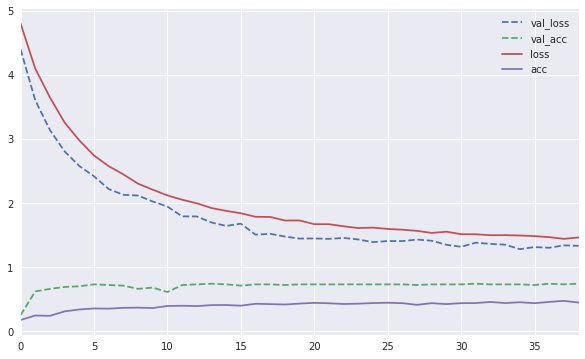

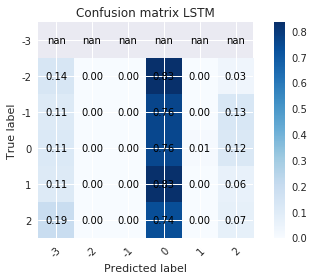

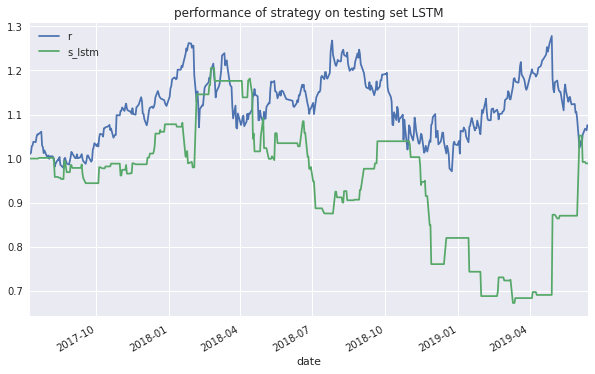

In [15]:
################################# LSTM ###################################
# Keras LSTM ML model & backtesting

units = 100

model = Sequential()
model.add(LSTM(units, activation='relu',return_sequences=True,
                kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),input_shape=(lags,len(features))
                )
)
    
model.add(BatchNormalization())
model.add(Dropout(0.3, seed=100))
model.add(BatchNormalization())
model.add(LSTM(units, activation='relu',
                kernel_regularizer=l2(0.01)
               )
         )
model.add(BatchNormalization())
model.add(Dropout(0.3, seed=100))
model.add(BatchNormalization())
model.add(Dense(len(clfi)+1,kernel_regularizer=l2(0.01), 
                activation='sigmoid'
                ))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
callbacks = [EarlyStopping(monitor='val_acc', patience=25)]

categorical_labels = to_categorical(train['d'])
categorical_labels1 = to_categorical(val['d'])
categorical_labels2 = to_categorical(test['d'])

get_ipython().run_cell_magic(u'time', u'', u"model.fit(np.array(train[cols]).reshape(len(train),lags,len(features)), np.array(categorical_labels),\n          epochs=250, batch_size=32, verbose=False,\n          validation_data=(np.array(val[cols]).reshape(len(val),lags,len(features)), np.array(categorical_labels1)),\n          callbacks=callbacks);")

res = pd.DataFrame(model.history.history)
res.tail(3)
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);

#Evaluate model
print(model.evaluate(np.array(test[cols]).reshape(len(test),lags,len(features)), np.array(categorical_labels2)))

#Predict returns for test set
test['p'] = model.predict_classes(np.array(test[cols]).reshape(len(test),lags,len(features)))
if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3


plot_confusion_matrix(y_true, test['p'], classes=clfi,title='Confusion matrix LSTM')
#Backtesting    
test['s_lstm'] = test['p'] * test['r']
print(test[['r', 's_lstm']].sum().apply(np.exp))
sum(test['p'].diff() != 0)
test['p'].value_counts()
test[['r', 's_lstm']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="performance of strategy on testing set LSTM")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               32128     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total para

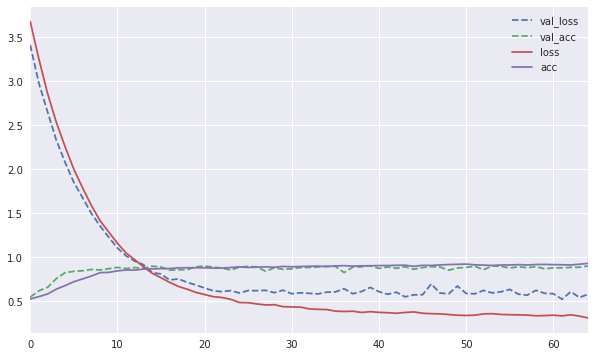

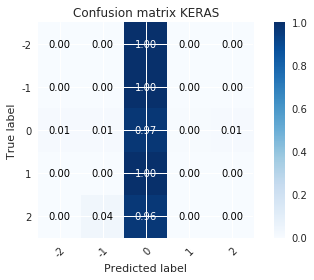

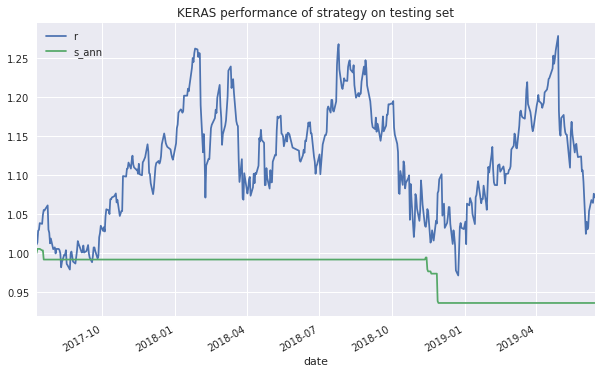

In [16]:
################################# Neural Nets ###################################


## Keras ML model & backtesting


model = Sequential()
model.add(Dense(128, activation='relu',
                kernel_regularizer=l2(0.01),
                input_shape=(len(cols),)
               )
         )
model.add(BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None))
model.add(Dropout(0.3, seed=100))
model.add(Dense(128, activation='relu',
                kernel_regularizer=l2(0.01)
               )
         )
model.add(BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None))
model.add(Dropout(0.3, seed=100))
model.add(Dense(len(clfi)+1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



model.summary()
callbacks = [EarlyStopping(monitor='val_acc', patience=25)]
get_ipython().run_cell_magic(u'time', u'', u"model.fit(train[cols], np.array(categorical_labels),\n          epochs=250, batch_size=32, verbose=False,\n          validation_data=(val[cols], np.array(categorical_labels1)),\n          callbacks=callbacks);")
res = pd.DataFrame(model.history.history)
res.tail(3)
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);


#Evaluate model
print(model.evaluate(test[cols], np.array(categorical_labels2)))
#Predict returns for test set
test['p'] = model.predict_classes(test[cols])
if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3
    
plot_confusion_matrix(y_true, test['p'], classes=clfi,title='Confusion matrix KERAS')

#Backtesting 
test['s_ann'] = test['p'] * test['r']
print(test[['r', 's_ann']].sum().apply(np.exp))
sum(test['p'].diff() != 0)
test['p'].value_counts()
test[['r', 's_ann']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="KERAS performance of strategy on testing set");

r         1.071432
s_dtr     0.570692
s_adar    0.764363
dtype: float64
Accuracy: 0.21161825726141079
Normalized confusion matrix
[[0.         0.         0.18644068 0.81355932 0.        ]
 [0.         0.         0.14545455 0.85454545 0.        ]
 [0.         0.         0.14096916 0.85903084 0.        ]
 [0.         0.         0.16666667 0.83333333 0.        ]
 [0.         0.         0.07017544 0.92982456 0.        ]]
r        1.071432
s_ada    1.230845
dtype: float64


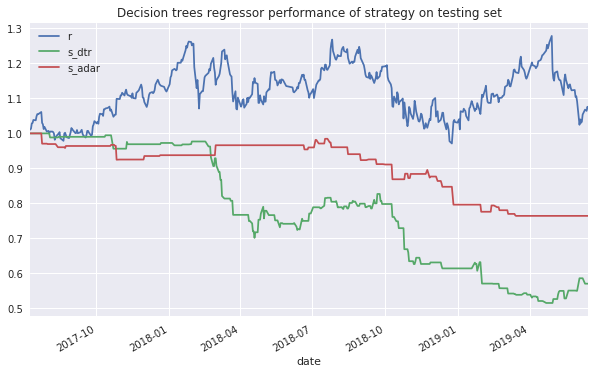

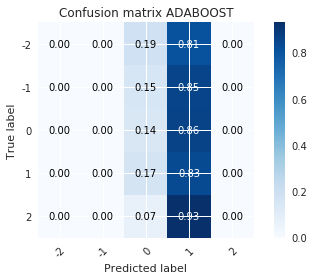

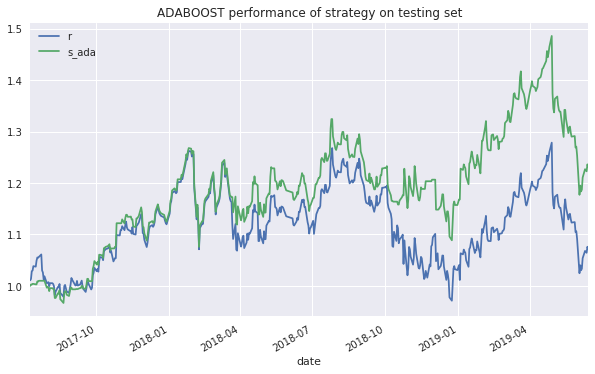

In [17]:
################################# DECISION TREES ###################################
SVM_SVC = SVC(C=1, probability=True)
naivebayes = BernoulliNB()
## DECISION TREES ML model & backtesting
rng = np.random.RandomState(1)
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=rng)
regr_1.fit(train[cols], train['d'])
regr_2.fit(train[cols], train['d'])
#Predict returns for test set
test['p'] = regr_1.predict(test[cols])
test['p_adar'] = regr_2.predict(test[cols])

if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
    test['p_adar'] = np.where(test['p_adar'] > 0, 1, -1)
else:
    test['p']=test['p']-3
    test['p']=round(test['p']);
    test['p_adar']=test['p_adar']-3
    test['p_adar']=round(test['p_adar']);

#Backtesting 
test['s_dtr'] = test['p'] * test['r']
test['s_adar'] = test['p_adar'] * test['r']
print(test[['r', 's_dtr','s_adar']].sum().apply(np.exp))
sum(test['p'].diff() != 0)
test['p'].value_counts()
test[['r', 's_dtr','s_adar']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="Decision trees regressor performance of strategy on testing set");

#dot_data = tree.export_graphviz(regr_1)
#graph = graphviz.Source(dot_data,filename='tempy', format='png')
#graph.render() # tree saved to wine.pdf


## XGBOOST ML model & backtesting

#np.random.seed(100)
#tf.random.set_random_seed(100)
if multinomial_ret==0:
    model = xgb.XGBClassifier()
    model.fit(train[cols], train['d'])
    
    #Predict returns for test set
    test['p'] = model.predict(test[cols])
    test['p'] = np.where(test['p'] > 0, 1, -1)
    
    #Backtesting 
    test['s_xgb'] = test['p'] * test['r']
    print(test[['r', 's_xgb']].sum().apply(np.exp))
    sum(test['p'].diff() != 0)
    test['p'].value_counts()
    test[['r', 's_xgb']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="XGBOOST performance of strategy on testing set");

else:
    test['s_xgb']=0



## ADABOOST ML model & backtesting
# Create adaboost classifer object

model = AdaBoostClassifier(n_estimators=500,learning_rate=1)
# Train Adaboost Classifer
model.fit(train[cols], train['d'])
#Predict the response for test dataset
test['p'] = model.predict(test[cols])

#Evaluate model
print("Accuracy:",accuracy_score(test['d'], test['p']))

if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3

plot_confusion_matrix(y_true, test['p'], classes=clfi,title='Confusion matrix ADABOOST')

#Backtesting 
test['s_ada'] = test['p'] * test['r']
print(test[['r', 's_ada']].sum().apply(np.exp))
sum(test['p'].diff() != 0)
test['p'].value_counts()
test[['r', 's_ada']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="ADABOOST performance of strategy on testing set")

#export the learned decision tree
#dot_data = tree.export_graphviz(model, out_file=None,
#                         feature_names=cols,
#                         class_names=[0,1],
#                         filled=True, rounded=True,
#                         special_characters=True)
#dot_data = tree.export_graphviz(model.estimators_[0])
#graph = graphviz.Source(dot_data,filename='tempy', format='png')
#graph.render() # tree saved to wine.pdf

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Prediction Accuracy of traning set is 
0.517799352750809
Prediction Accuracy of testing set is 
0.470954356846473
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      59.0
           2       0.00      0.00      0.00      55.0
           3       0.00      0.00      0.00     227.0
           4       0.00      0.00      0.00      84.0
           5       0.00      0.00      0.00      57.0

    accuracy                           0.00     482.0
   macro avg       0.00      0.00      0.00     482.0
weighted avg       0.00      0.00      0.00     482.0

Normalized confusion matrix
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[  0   0   0   0   0   0]
 [ 59   0   0   0   0   0]
 [ 55   0   0   0   0   0]
 [227   0   0   0   0   0]
 [ 84   0   0   0   0   0]
 [ 57   0   0   0   0   0]]


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


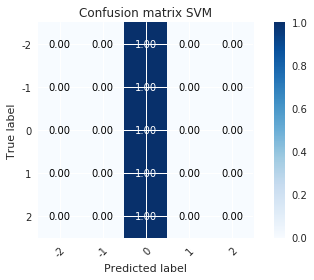

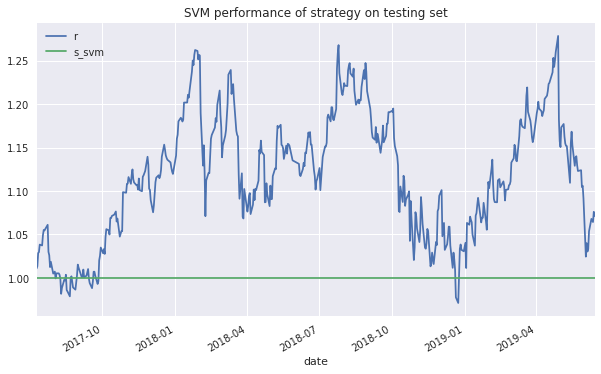

In [18]:
################################# SVM ###################################

## SVM ML model & backtesting
SVM_SVC = SVC(C=1, probability=True)
SVM_SVC.fit(train[cols], train['d']) ###FITTING DONE HERE
    
print("Prediction Accuracy of traning set is ")
    
print(accuracy_score(SVM_SVC.predict(train[cols]),train['d']))
print("Prediction Accuracy of testing set is ")
print(accuracy_score(SVM_SVC.predict(test[cols]),test['d']))

#Predict returns for test set
test['p'] = SVM_SVC.predict(test[cols])

if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3

#Backtesting 
test['s_svm'] = test['p'] * test['r']
test[['r', 's_svm']].sum().apply(np.exp)
sum(test['p'].diff() != 0)
test['p'].value_counts()

conf_mat = confusion_matrix(test['d'], test['p'])
print(classification_report(test['d'], test['p']))


plot_confusion_matrix(y_true, test['p'], classes=clfi,title='Confusion matrix SVM')

print(conf_mat)

test[['r', 's_svm']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="SVM performance of strategy on testing set")

#test[['r','s_lstm','s_ann','s_ada', 's_svm','s_xgb']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="LSTM, ANN, SVM, XGBoost, ADABoost performance of strategy on testing set")

#test1=test

KFold(n_splits=5, random_state=7, shuffle=False)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5-fold crossvalidation accuracy: 0.3529
              precision    recall  f1-score   support

           1       0.09      0.15      0.12        59
           2       0.09      0.07      0.08        55
           3       0.40      0.31      0.35       227
           4       0.16      0.19      0.18        84
           5       0.17      0.21      0.19        57

    accuracy                           0.23       482
   macro avg       0.18      0.19      0.18       482
weighted avg       0.26      0.23      0.24       482

[[ 9  2 22 18  8]
 [15  4 22  8  6]
 [48 29 70 47 33]
 [15  6 35 16 12]
 [10  3 24  8 12]]
Normalized confusion matrix
[[0.15254237 0.03389831 0.37288136 0.30508475 0.13559322]
 [0.27272727 0.07272727 0.4        0.14545455 0.10909091]
 [0.21145374 0.1277533  0.30837004 0.20704846 0.14537445]
 [0.17857143 0.07142857 0.41666667 0.19047619 0.14285714]
 [0.1754386  0.05263158 0.42105263 0.14035088 0.21052632]]
KFold(n_splits=5, random_state=7, shuffle=False)
5-fold cross

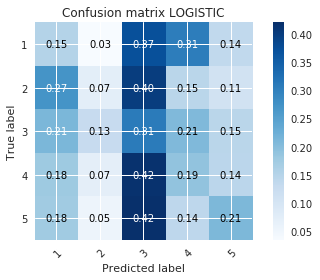

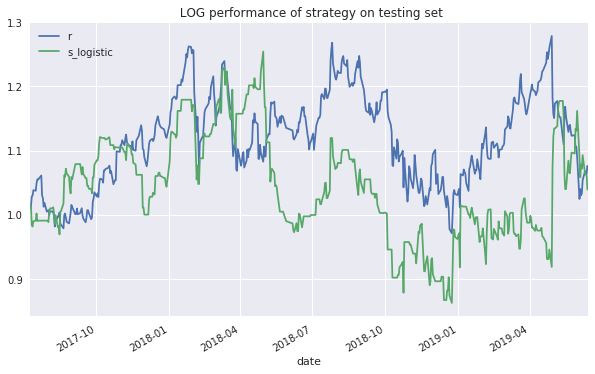

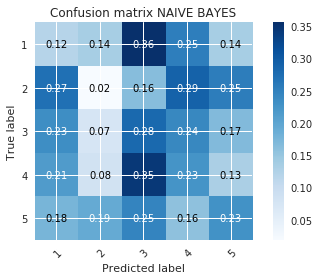

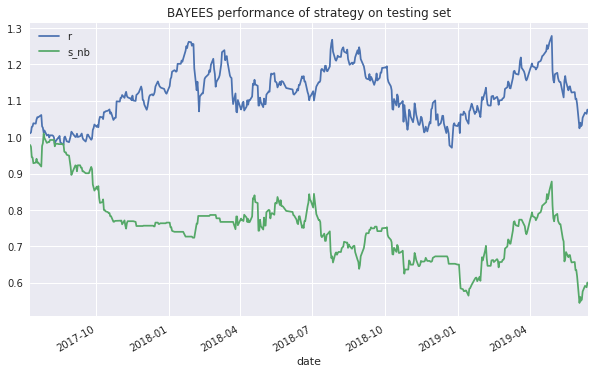

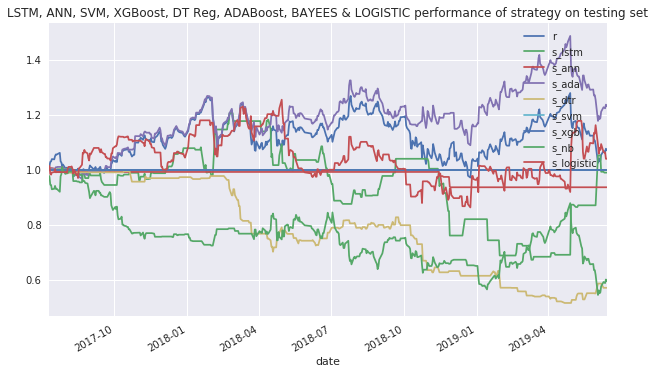

In [19]:
################################ LOGISTIC & NAIVE BAYEES ###################################
## LOGISTIC ML model & backtesting

logit = linear_model.LogisticRegression(C=1,multi_class='auto',solver='lbfgs',max_iter=10000)
    
kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=False) # RandomState is the seed used by the RNG

print(kfold)

#print(kfold.get_n_splits(X_Features)) # returns the number of splitting iterations in the cross-validator


#Fit &Evaluate model 
crossval = model_selection.cross_val_score(logit, train[cols], train['d'], cv=kfold, scoring='accuracy')
crossval_predict = model_selection.cross_val_predict(logit, test[cols], test['d'], cv=kfold)
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy


conf_mat = confusion_matrix(test['d'], crossval_predict)
print(classification_report(test['d'], crossval_predict))

print(conf_mat)

plot_confusion_matrix(test['d'], crossval_predict, classes=clfi,title='Confusion matrix LOGISTIC')
test['p'] = crossval_predict
if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3

#Backtesting 
test['s_logistic'] = test['p'] * test['r']
test[['r', 's_logistic']].sum().apply(np.exp)
sum(test['p'].diff() != 0)
test['p'].value_counts()
    

test[['r', 's_logistic']].cumsum().apply(np.exp).plot(figsize=(10, 6),title=" LOG performance of strategy on testing set")


## NAIVE BAYEES ML model & backtesting


naivebayes = BernoulliNB()
kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=False) # RandomState is the seed used by the RNG

print(kfold)

#Fit &Evaluate model 
crossval = model_selection.cross_val_score(naivebayes, train[cols], train['d'], cv=kfold, scoring='accuracy')
crossval_predict = model_selection.cross_val_predict(naivebayes, test[cols], test['d'], cv=kfold)
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean())) #average accuracy

conf_mat = confusion_matrix(test['d'], crossval_predict)
print(classification_report(test['d'], crossval_predict))

print(conf_mat)

plot_confusion_matrix(test['d'], crossval_predict, classes=clfi,title='Confusion matrix NAIVE BAYES')
test['p'] = crossval_predict

if len(clfi)<2:
    test['p'] = np.where(test['p'] > 0, 1, -1)
else:
    test['p']=test['p']-3

#Backtesting 
test['s_nb'] = test['p'] * test['r']
test[['r', 's_nb']].sum().apply(np.exp)
sum(test['p'].diff() != 0)
test['p'].value_counts()

test[['r', 's_nb']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="BAYEES performance of strategy on testing set")

test[['r','s_lstm','s_ann','s_ada','s_dtr', 's_svm','s_xgb', 's_nb','s_logistic']].sum().apply(np.exp)

test[['r','s_lstm','s_ann','s_ada','s_dtr', 's_svm','s_xgb', 's_nb','s_logistic']].cumsum().apply(np.exp).plot(figsize=(10, 6),title="LSTM, ANN, SVM, XGBoost, DT Reg, ADABoost, BAYEES & LOGISTIC performance of strategy on testing set")

In [23]:
returns = test[['r','s_lstm','s_ann','s_ada','s_dtr', 's_svm','s_xgb', 's_nb','s_logistic']]

In [41]:
def calc_sharpe(returns, rfr = 0.02, window = 252):
    rfr_daily = rfr / 252 #risk free rate

    annualised_sharpe = np.sqrt(252) * (returns.rolling(window).mean() - rfr_daily) / returns.rolling(window).std()
    annualised_sharpe = annualised_sharpe.replace([np.inf, -np.inf], np.nan)
    
    return annualised_sharpe

def drawdown(returns):
    return returns.cumsum() - returns.cumsum().cummax()

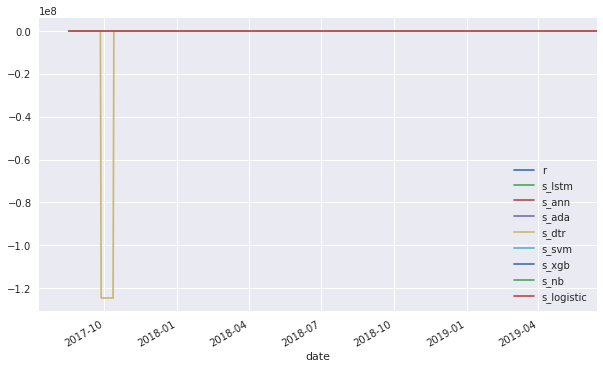

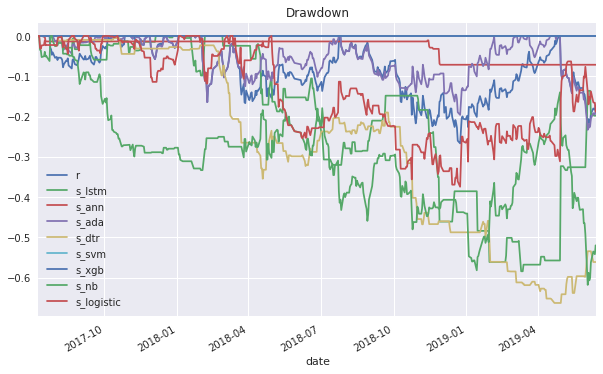

In [42]:
calc_sharpe(returns, 0.02, 30).plot(figsize = (10, 6), title = "Sharpe")
drawdown(returns).plot(figsize = (10, 6), title = "Drawdown")

In [24]:
rfr_daily = 0.02 / 252 #risk free rate

annualised_sharpe = np.sqrt(252) * (returns.rolling(30).mean() - rfr_daily) / returns.rolling(30).std()
annualised_sharpe.tail()

,r,s_lstm,s_ann,s_ada,s_dtr,s_svm,s_xgb,s_nb,s_logistic
date,,,,,,,,,
2019-06-10,-3.874010,3.422881,-inf,-4.179714,2.981065,-inf,-inf,-5.362641,1.539475
2019-06-11,-4.304460,3.391022,-inf,-4.620724,2.981065,-inf,-inf,-5.965517,1.931068
2019-06-12,-3.153816,1.774217,-inf,-3.536059,2.981065,-inf,-inf,-5.168960,-0.256677
2019-06-13,-2.217463,1.774217,-inf,-2.588301,2.376420,-inf,-inf,-4.143481,-1.604124
2019-06-14,-2.174276,1.774217,-inf,-2.544663,2.376420,-inf,-inf,-4.096612,-1.852503


In [28]:
disp_cols.remove('s_dtr')

In [29]:
disp_cols = annualised_sharpe.columns.to_list()
disp_cols.remove('s_dtr')
disp_cols.remove('s_ada')

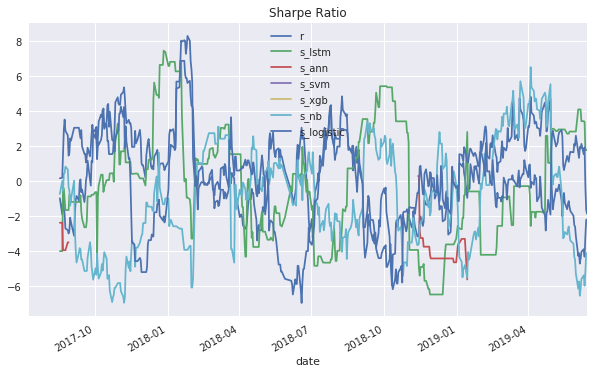

In [30]:
annualised_sharpe[disp_cols].replace([np.inf, -np.inf], np.nan).plot(figsize = (10, 6), title = "Sharpe Ratio")


In [ ]:
def drawdown(returns):
    return returns.cumsum() - returns.cumsum().cummax()

drawdown(returns).plot(figsize = (10, 6), title = "Drawdown")